# CLL788 Term Paper Assignment

## Topic: LIPNET: END-TO-END SENTENCE-LEVEL LIPREADING
## By: Yannis M. Assael, Brendan Shillingford, Shimon Whiteson and Nando de Freitas
Paper Link: https://arxiv.org/abs/1611.01599

## By: Meet Jain
## Entry Number: 2023PHS7210

# 0. Initial Verification

In [ ]:
# Uncomment and run the below commands to install the required packages
# !pip install -r requirements.txt

In [ ]:
# Run the below command to verify the proper package installations(Ignore the warnings)
!python3 test_environment.py

# 1. Libraries Import

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import gdown
from pathlib import Path
import dlib
from tqdm import tqdm

2025-03-21 02:56:15.671072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742525775.688154    8859 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742525775.692932    8859 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742525775.705940    8859 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742525775.705970    8859 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742525775.705972    8859 computation_placer.cc:177] computation placer alr

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

2025-03-21 02:56:18.424277: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# 2. Dataset Download
Uncomment and run the below cell to download the dataset

In [4]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

# 3. Data Pipeline

In [5]:
VIDEO_DIR = "data/s1"
ALIGN_DIR = "data/alignments/s1"
video_files = sorted([f for f in os.listdir(VIDEO_DIR) if f.endswith(".mpg")])
print(video_files[:5])

['bbaf2n.mpg', 'bbaf3s.mpg', 'bbaf4p.mpg', 'bbaf5a.mpg', 'bbal6n.mpg']


In [6]:
MOUTH_H, MOUTH_W = 50, 100  # Mouth crop size
CHANNELS = 3  # RGB

## 3.1 Mouth Region Extraction

Uncomment below cell and run to download the pretrained face detector model as used in the paper.

In [8]:
# !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# !bunzip2 shape_predictor_68_face_landmarks.dat.bz2

In [9]:
# Initializing the pre-trained face detector model from DLib package to extract the mouth regions from each of the frames.
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [10]:
def extract_mouth_region(frame:np.array):
    # Convert to grayscale for detection only
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) == 0:
        return None
    # Using the first detected face
    face = faces[0]
    landmarks = predictor(gray, face)
    # Landmarks corresponding to the mouth: 48-68
    points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 68)]
    points = np.array(points)
    
    # Bounding box around the mouth landmarks
    x, y, w, h = cv2.boundingRect(points)
    margin = 10
    x = max(x - margin, 0)
    y = max(y - margin, 0)
    cropped = frame[y:y+h+margin, x:x+w+margin]
    # Resize to 100x50, keeping all 3 channels
    cropped = cv2.resize(cropped, (MOUTH_W, MOUTH_H))
    return cropped

def process_video(video_path:str, output_dir:str) -> None:
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for _ in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break
        mouth_frame = extract_mouth_region(frame)
        if mouth_frame is not None:
            frames.append(mouth_frame)
        else:
            # If detection fails
            frames.append(np.zeros((50, 100, 3), dtype=np.uint8))
    cap.release()

    video_id = os.path.splitext(os.path.basename(video_path))[0]
    np.save(os.path.join(output_dir, f"{video_id}_mouth.npy"), np.array(frames))
    return None

# input_videos_dir = VIDEO_DIR
# output_preprocessed_dir = "./processed_mouth_data/s1"
# os.makedirs(output_preprocessed_dir, exist_ok=True)
# video_files = [os.path.join(input_videos_dir, f) for f in os.listdir(input_videos_dir) if f.endswith(".mpg")]

# for video_file in tqdm(video_files, desc="Overall video processing", unit="video"):
#     process_video(video_file, output_preprocessed_dir)

Overall video processing:  84%|████████▍ | 840/1000 [11:46<02:16,  1.18video/s][mpeg1video @ 0xca170c0] ac-tex damaged at 22 17
[mpeg1video @ 0xca170c0] Warning MVs not available
Overall video processing: 100%|██████████| 1000/1000 [14:01<00:00,  1.19video/s]


In [15]:
def create_gif_from_npy(npy_path:str, gif_path:str, duration:float=0.04) -> None:
    frames = np.load(npy_path)  # Expected shape: (num_frames, height, width, channels)
    # The duration parameter sets the time per frame, 0.04s for 25fps.
    imageio.mimsave(gif_path, frames, duration=duration)
    return None

npy_path = "./processed_mouth_data/s1/bbaf3s_mouth.npy"
gif_path = "./bbaf2n_mouth.gif"
create_gif_from_npy(npy_path, gif_path)

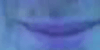

In [16]:
# See the extracted mouth region as a GIF file.
from IPython.display import Image, display
gif_path = "./bbaf2n_mouth.gif"
display(Image(filename=gif_path))

## 3.2 Constructing Vocabulary and Character Mapping

In [17]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz "]
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_(' ')] (size =28)


In [19]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [20]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

## 3.3 Video Loading

In [30]:
def load_and_normalize_video(npy_path):
    """
    Loads a preprocessed video from a .npy file, normalizes each channel using the
    specified per-channel means and standard deviations, and returns a TensorFlow tensor.

    Parameters:
        npy_path (str): Path to the .npy file containing the video frames.
                        Expected shape: (num_frames, height, width, 3) in BGR order.

    Returns:
        tf.Tensor: Normalized video frames tensor in RGB order.
    """
    frames = np.load(npy_path)  # shape: (T, H, W, 3)
    frames = frames.astype(np.float32) / 255.0
    frames = frames[..., ::-1] # BGR to RGB
    
    # Per-channel means and standard deviations from the paper (for R, G, B)
    means = np.array([0.7136, 0.4906, 0.3283], dtype=np.float32)
    stds  = np.array([0.1138, 0.1078, 0.0917], dtype=np.float32)
    
    # Normalizing the channels
    frames = (frames - means) / stds
    
    video_tensor = tf.convert_to_tensor(frames)
    return video_tensor

# Example usage:
npy_path = "./processed_mouth_data/s1/bbaf3s_mouth.npy"
video_tensor = load_and_normalize_video(npy_path)
print(video_tensor.shape)

(75, 50, 100, 3)


## 3.4 Alignment Loading Function

In [50]:
def load_alignments(align_file:str) -> List[str]:
    """
    Reads an alignment file and returns a list of tuples (start, end, token).
    
    Parameters:
        align_file (str): Path to the .align file.
        time_unit (float): A factor to scale the time stamps (default is 1, i.e. no scaling).
        frame_rate (float or None): If provided, converts time stamps (assumed in ms)
            to frame indices. For example, if times are in ms and frame_rate is 25,
            then one frame corresponds to 40ms.
    
    Returns:
        List[Tuple[int, int, str]]: A list where each element is (start, end, token).
    """
    alignments = []
    with open(align_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 3:
                continue  # skip malformed lines
            _, _, token = parts
            if token != 'sil':
                token_characters = list(token.lower()+' ')
                alignments.extend(token_characters)
    return alignments[:-1]

# Example usage:
align_file_path = "./data/alignments/s1/bbaf2n.align"
alignments = load_alignments(align_file_path)
print(alignments)

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'f', ' ', 't', 'w', 'o', ' ', 'n', 'o', 'w']


## 3.5 Video and Alignments pair Loading

In [64]:
def load_data(path: tf.Tensor):
    path = bytes.decode(path.numpy())
    # Extract the file name
    file_name = os.path.splitext(os.path.basename(path))[0]
    
    # Build the paths to the video (.npy file) and its corresponding alignment file
    video_path = os.path.join('./processed_mouth_data/s1', f'{file_name}.npy')
    alignment_path = os.path.join('./data/alignments/s1', f'{file_name[:-6]}.align')
    
    # Load the video frames and the alignment information
    frames = load_and_normalize_video(video_path)
    alignments = load_alignments(alignment_path)
    alignments_mapped = char_to_num(alignments)
    
    return frames, alignments_mapped

def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [65]:
os.path.splitext(os.path.basename(test_path))[0][:-6]

'bbaf3s'

In [66]:
os.path.splitext(os.path.basename(bytes.decode(tf.convert_to_tensor(test_path).numpy())))

('bbaf3s_mouth', '.npy')

In [67]:
test_path = "./processed_mouth_data/s1/bbaf3s_mouth.npy"
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [72]:
num_to_char(alignments)

<tf.Tensor: shape=(24,), dtype=string, numpy=
array([b'b', b'i', b'n', b' ', b'b', b'l', b'u', b'e', b' ', b'a', b't',
       b' ', b'f', b' ', b't', b'h', b'r', b'e', b'e', b' ', b's', b'o',
       b'o', b'n'], dtype=object)>

In [91]:
imageio.mimsave('./bbaf3s.gif', frames.numpy(), duration=0.04)

TypeError: Cannot handle this data type: (1, 1, 3), <f4

In [88]:
type(frames.numpy())

numpy.ndarray

In [90]:
frames.numpy().shape

(75, 50, 100, 3)